In [148]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols
import matplotlib.pyplot as plt

import pandas as pd

from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
#https://github.com/bp-kelley/descriptastorus


# Input both test/training dataset 

In [149]:
full_copy = pd.read_csv('../../../project1_data/Series4_full.csv', index_col = 'ID')

# full_copy['class'] = np.where(full_copy.desired >=5 , True, np.where(full_copy.desired < 5, False))

full_copy.loc[full_copy['clearance'] <5, 'class'] = 'stable'
full_copy.loc[full_copy['clearance'] >=5, 'class'] = 'unstable'

# allMerged.drop(allMerged[allMerged.clearance > 49.9].index, inplace=True)

PandasTools.AddMoleculeColumnToFrame(full_copy,smilesCol='SMILES')


<AxesSubplot:xlabel='clearance', ylabel='Density'>

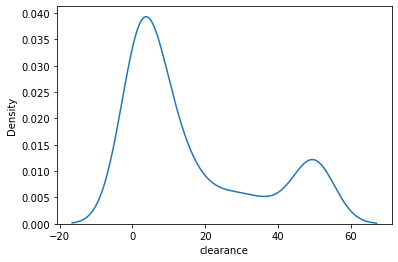

In [150]:
# plotting kde for the desired property
import seaborn as sns

sns.kdeplot(data=full_copy, x="clearance")

# sns.displot(data=full_copy, x="clearance")


# Generating descriptors using RDKit

In [151]:
# RDKit
generator = MakeGenerator(("RDKit2D",))

full_copy_rdkit2d = [generator.process(x)[1:] for x in full_copy['SMILES']]

In [152]:
rdkit2d_name = []
for name, numpy_type in generator.GetColumns():
    rdkit2d_name.append(name)
    
full_copy_rdkit2d_df = pd.DataFrame(full_copy_rdkit2d, index = full_copy.index, columns=rdkit2d_name[1:])

In [153]:
# full_copy_rdkit2d_df.head()

# MACCS keys 

In [154]:
# full_copy_MAACS = [MACCSkeys.GenMACCSKeys(x) for x in full_copy['ROMol']]
# full_copy_MAACS_list = [list(l) for l in full_copy_MAACS]
# maccs_name = [f'Bit_{i}' for i in range(167)]
# full_copy_MAACS_df = pd.DataFrame(full_copy_MAACS_list, index = full_copy.index, columns=maccs_name)
# full_copy_MAACS_df

In [155]:
# Mergind MACCS and RDKit descriptors

# full_copy_rdkit2d_df = pd.merge(full_copy_MAACS_df,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
# full_copy_rdkit2d_df.shape

In [156]:
full_copy_rdkit2d_df.to_csv('../../../project1_data/from_PP/full_copy_rdkit2d_df.csv')

In [157]:
# TrainTest=full_copy.drop(full_copy[full_copy.type == 'validation'].index)
# TrainTest.drop(TrainTest[TrainTest.type == 'excluded'].index, inplace=True)
# TrainTest.drop(TrainTest[TrainTest.type == 'excluded_subset'].index, inplace=True)

# # full_copy.shape
# validation=full_copy.drop(full_copy[full_copy.type == 'TestTrain'].index)
# validation.drop(validation[validation.type == 'excluded'].index, inplace=True)
# validation.drop(validation[validation.type == 'excluded_subset'].index, inplace=True)

# excluded=full_copy.drop(full_copy[full_copy.type == 'TestTrain'].index)
# excluded.drop(excluded[excluded.type == 'validation'].index, inplace=True)
# excluded.drop(excluded[excluded.type == 'excluded'].index, inplace=True)


# TrainTest.head()

# Including PP data

In [158]:
full_copy_rdkit2d_df = pd.read_csv('../../../project1_data/from_PP/desirable-database_2020-09-10_ONLY-PPP-descriptors.csv', index_col = 'ID')
full_copy_rdkit2d_df.head()
# allMerged = pd.merge(TrainTest,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
# allMerged_validation = pd.merge(validation,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
# allMerged_excluded = pd.merge(excluded,full_copy_rdkit2d_df,left_on='ID',right_on='ID')

allMerged = pd.merge(full_copy,full_copy_rdkit2d_df,left_on='ID',right_on='ID')

allMerged.shape

(346, 174)

In [159]:
# allMerged.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard', 'LgD9_VS', 'LgD10_VS', 'LgD7_5_VS', 'LgD7_VS', 'LgD6_VS', 'ALogP'], axis=1, inplace=True)
allMerged.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard'], axis=1, inplace=True)
# allMerged_validation.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard'], axis=1, inplace=True)
# allMerged_excluded.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard'], axis=1, inplace=True)


# allMerged.drop(['desired'], axis=1, inplace=True)
# allMerged_validation.drop(['desired'], axis=1, inplace=True)
# # allMerged_validation.drop(allMerged_validation[allMerged_validation.clearance < 7].index, inplace=True)
# allMerged_excluded.drop(['desired'], axis=1, inplace=True)
# allMerged_excluded.drop(allMerged_excluded[allMerged_excluded.clearance < 7].index, inplace=True)

allMerged.drop(['clearance','desired_type', 'desired'], axis=1, inplace=True)
allMerged.dropna(inplace=True)


In [160]:
allMerged.to_csv('../../../project1_data/from_PP/mergedData_clearance.csv')

# Random forest 

In [161]:
X = allMerged.iloc[:, 2:,].values #descreptors
# y = allMerged.iloc[:, 1].values #desired property

y = allMerged['class'].to_numpy()
# y.shape

(251, 163)


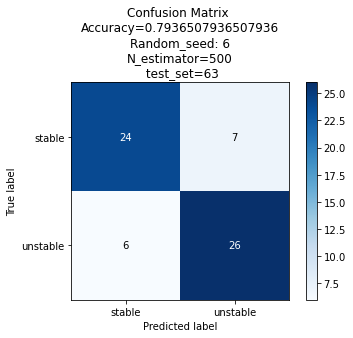

[6]
[0.7936507936507936]


In [162]:
# print(X.shape)
# print(y)

# Plotting confusion matrix:
def plot_confusion_matrix(y_test, y_pred, accuracy_score, random_seed, N_estimator, test_set_size):
    """
    Plots confusion matrix along with associated properties for bookkeeping.
    """
    import scikitplot as skplt
    skplt.metrics.plot_confusion_matrix(y_test, y_pred)
    plt.title('Confusion Matrix \nAccuracy=' + str(accuracy_score) +"" + "\nRandom_seed: " +
              str(random_seed) +
              '\nN_estimator='+str(N_estimator)+
             '\n test_set='+str(test_set_size))
    plt.show()




r2_list = []
random_state_variable_list = []

n_estimator_variable=500

for f in range(6,7,1):

    random_state_variable=f
    random_state_variable_list.append(f)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_variable)
    print(X_train.shape)
    # print(X_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)

    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    
#     writing out X_train as dataframe
    X_training_data = pd.DataFrame(columns=allMerged.columns[2:], 
                                   data=X_train)
    
    X_training_data.to_csv('../../../project1_data/from_PP/training_data.csv')
    
    X_test = sc.transform(X_test)
#     print(X_train[0])

    ### Starting Random Forest fitting

    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

    regressor = RandomForestClassifier(n_estimators=n_estimator_variable, random_state=random_state_variable)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    from sklearn import metrics
    test_set_size=y_test.shape[0]

#     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    r2_list.append(metrics.accuracy_score(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, metrics.accuracy_score(y_test, y_pred), 
                          random_state_variable, n_estimator_variable,
                          test_set_size)

  
print (random_state_variable_list)
print (r2_list)

# Validation



# Visualising leaves

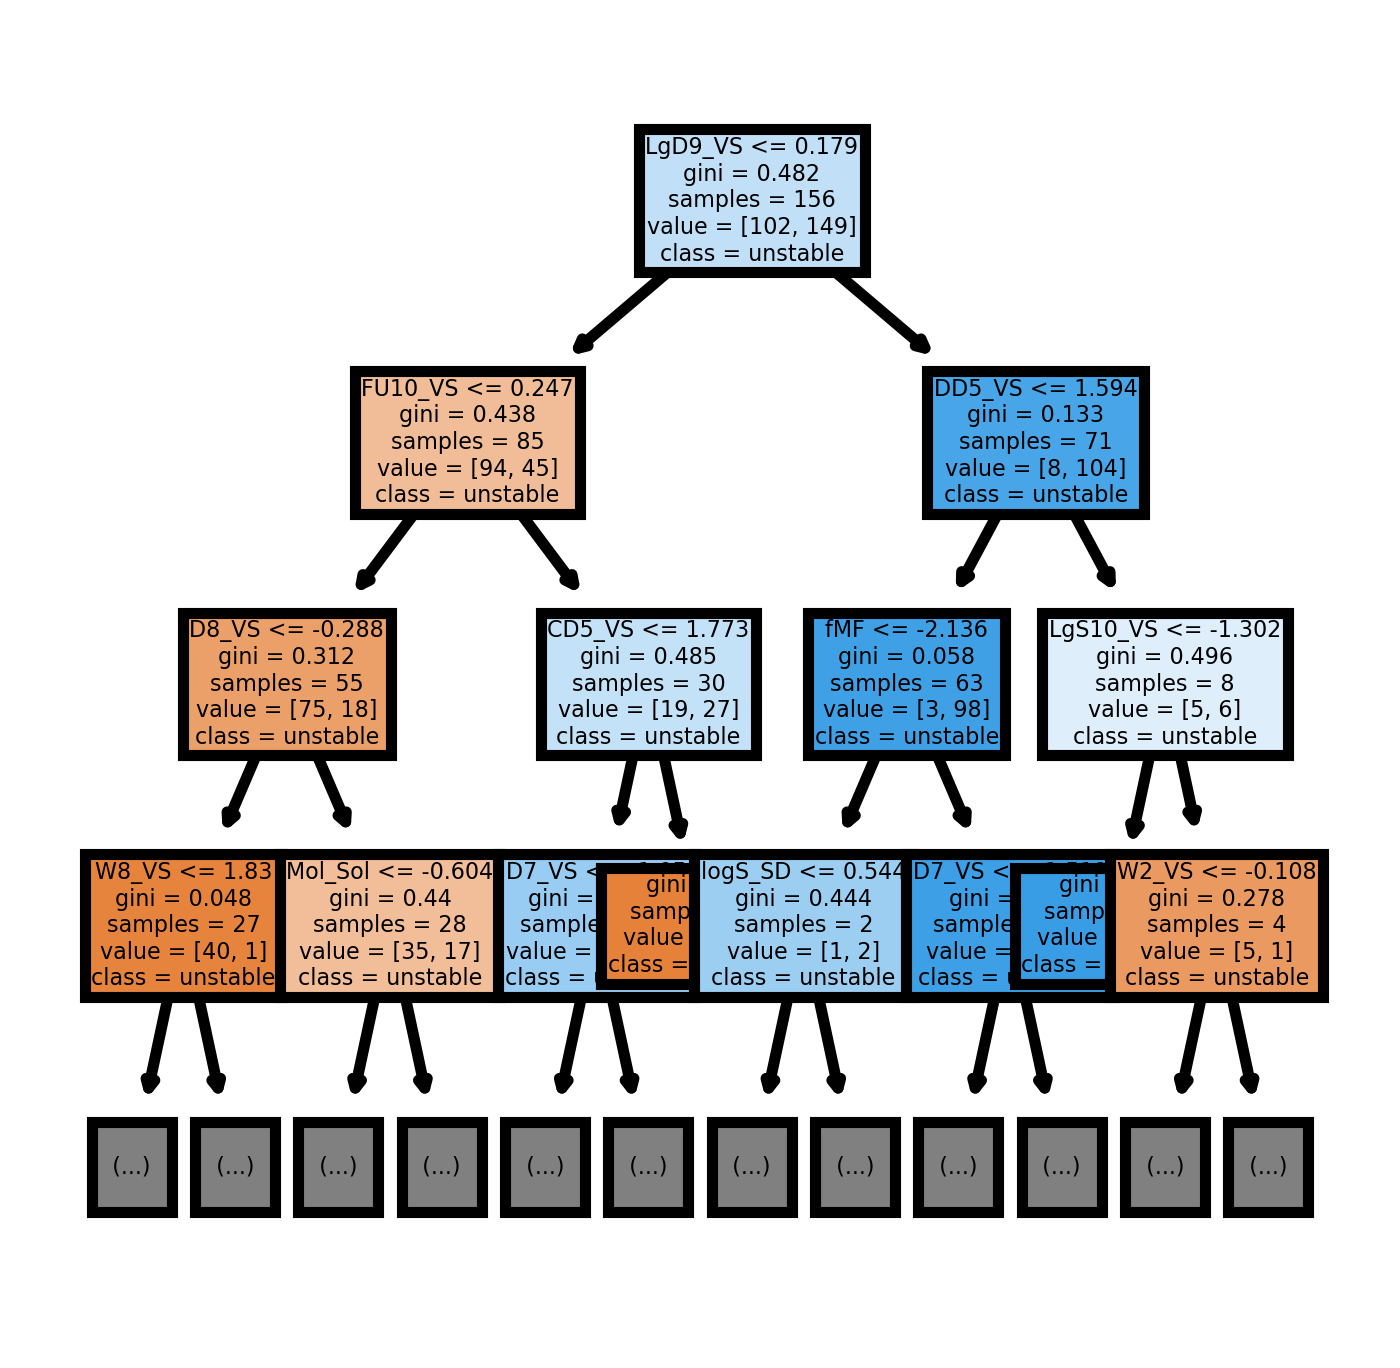

In [163]:
# def top2_important_properties(estimator):
#     """
#     Takes estimator as input and returns top2 important properties for that given estimator
#     """
#     important_properties = pd.DataFrame({"Descriptors" : allMerged.columns[2:], "importance" : estimator.feature_importances_})
#     Top2_properties = important_properties.sort_values(by=['importance'], ascending=False, ignore_index=True)[:2]
#     return Top2_properties

# # print(len(regressor.estimators_))

# first_time=True

# for f in range(0,10,1):
#     estimator = regressor.estimators_[f]
#     allMerged.columns[2:]
#     allMerged.columns[1]
#     if first_time:
#         concat_top2 = top2_important_properties(estimator)
#         first_time=False
#     else:
#         temp_top2 = top2_important_properties(estimator)
# #         print(type(temp_top2))
# #         print(type(concat_top2))
#         print("temp_top2 is ", temp_top2)
#         concat_top2.append(temp_top2)
    
    
# print("Done with loop")    
# print(concat_top2)

estimator = regressor.estimators_[1]
# print(estimator)
allMerged.columns[2:]
allMerged.columns[1]

# print(allMerged['class'])

fn=allMerged.iloc[:, 2:,].columns
cn=allMerged['class']

from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=800)
tree.plot_tree(estimator,
               feature_names = fn, 
               class_names=cn,
               filled = True,
               max_depth=3,
               fontsize = 2.0);
fig.savefig('RandomForest_PP_Clearance_classifier.png')

# Important parameters

In [164]:
important_properties = pd.DataFrame({"Descriptors" : allMerged.columns[2:], "importance" : regressor.feature_importances_})
important_properties.sort_values(by=['importance'], ascending=False).reset_index(drop=True).head(40)

,Descriptors,importance
0,LgD8_VS,0.042949
1,LgD9_VS,0.042514
2,LOGP_nOct_VS,0.036732
3,ALogP,0.036331
4,LgD10_VS,0.035721
5,LgD7_5_VS,0.028791
6,LgD7_VS,0.022675
7,LgD6_VS,0.022034
8,SKIN_VS,0.021091
9,logP_SD,0.020914


# Important properties

In [147]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.transform(allMerged)

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.